#  WEEK 3: BASELINE MODELS & INITIAL XGBOOST


---

##  Week 3 Objectives:

1.  Load preprocessed datasets
2.  Implement epsilon-MAPE metric (solve Week 1 problem!)
3.  Create simple baselines (median, persistence, sector mean)
4.  Build RandomForest baseline
5.  Train initial XGBoost model
6.  Compare all models
7.  Set benchmark for Week 4

---

##  Success Criteria:

**Week 1 Problem:** MAPE will explode (72%+)  
**Week 3 Target:** Epsilon-MAPE < 25% with baseline models

**Baselines:**
- Simple baselines: Expected MAPE ~30-40%
- RandomForest: Expected MAPE ~20-25%
- XGBoost (default): Expected MAPE ~18-22%

**Week 4 will optimize to < 15%!**

---

##  Data Ready:

From Week 2:
- Train: 5,897 rows × 67 features
- Val: 2,932 rows × 67 features
- Target: `revenue_change_log` (skewness: 0.10)

---

Import Libraries & Load Preprocessed Data

In [1]:
# ========================================
# CELL 2: Import Libraries & Load Preprocessed Data
# ========================================

# Core libraries
import pandas as pd
import numpy as np

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
plt.style.use('seaborn-v0_8-darkgrid')

print(" Libraries imported!")

# ========================================
# Load Preprocessed Data
# ========================================

print("\n" + "="*80)
print(" LOADING PREPROCESSED DATA")
print("="*80)

# Load datasets
train_df = pd.read_csv('../data/processed/train_preprocessed.csv')
val_df = pd.read_csv('../data/processed/val_preprocessed.csv')

print(f"\n Data loaded successfully!")
print(f"Train: {train_df.shape[0]:,} rows × {train_df.shape[1]} columns")
print(f"Val:   {val_df.shape[0]:,} rows × {val_df.shape[1]} columns")

# Define target variable
TARGET = 'revenue_change_log'
TARGET_ORIGINAL = 'revenue_change'
TARGET_CLIPPED = 'revenue_change_clipped'

print(f"\n Target variable: {TARGET}")

# Prepare features and target
# Exclude target variables and non-features
exclude_cols = [
    TARGET, 
    TARGET_ORIGINAL, 
    TARGET_CLIPPED,
    'fiscal_year',
    'ateco_sector',
    'bankruptcy_next_year',
    'company_id',  # If exists
]

# Get feature columns
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

print(f"\n Features: {len(feature_cols)}")

# Create X and y
X_train = train_df[feature_cols]
y_train = train_df[TARGET]

X_val = val_df[feature_cols]
y_val = val_df[TARGET]

# Also keep original scale targets for evaluation
y_train_original = train_df[TARGET_ORIGINAL]
y_val_original = val_df[TARGET_ORIGINAL]

y_train_clipped = train_df[TARGET_CLIPPED]
y_val_clipped = val_df[TARGET_CLIPPED]

print(f"\n Train set: X={X_train.shape}, y={y_train.shape}")
print(f" Val set:   X={X_val.shape}, y={y_val.shape}")

# Check for missing values
print("\n" + "="*80)
print(" DATA QUALITY CHECK")
print("="*80)

train_missing = X_train.isnull().sum().sum()
val_missing = X_val.isnull().sum().sum()
target_missing = y_train.isnull().sum() + y_val.isnull().sum()

print(f"Features missing (train): {train_missing}")
print(f"Features missing (val):   {val_missing}")
print(f"Target missing:           {target_missing}")

if train_missing > 0 or val_missing > 0 or target_missing > 0:
    print("\n  WARNING: Missing values detected!")
else:
    print("\n No missing values! Data is clean!")

print("\n" + "="*80)
print(" DATA LOADING COMPLETE!")
print("="*80)

 Libraries imported!

 LOADING PREPROCESSED DATA

 Data loaded successfully!
Train: 5,897 rows × 67 columns
Val:   2,932 rows × 67 columns

 Target variable: revenue_change_log

 Features: 60

 Train set: X=(5897, 60), y=(5897,)
 Val set:   X=(2932, 60), y=(2932,)

 DATA QUALITY CHECK
Features missing (train): 23
Features missing (val):   10
Target missing:           0


 DATA LOADING COMPLETE!


Define Evaluation Metrics (Epsilon-MAPE)

In [ ]:
# ========================================
# CELL 3: Define Evaluation Metrics (Epsilon-MAPE) 
# ========================================

print("="*80)
print(" DEFINING EVALUATION METRICS")
print("="*80)

print("\n PROBLEM: Standard MAPE explodes with small denominators")
print(" SOLUTION: Epsilon-MAPE with epsilon=10.0 (10%)")

# Define inverse transform function
def inverse_signed_log(x):
    """Convert log-scale predictions back to original percentage scale"""
    return np.sign(x) * (np.exp(np.abs(x)) - 1)

# Epsilon-MAPE (MAIN METRIC - FIXED EPSILON!)
def epsilon_mape(y_true, y_pred, epsilon=10.0):
    """
    Epsilon-MAPE: Adds epsilon to denominator to prevent explosion.
    
    Formula: mean(|y_true - y_pred| / (|y_true| + epsilon)) * 100
    
    Args:
        epsilon: 10.0 = 10% (reasonable denominator for revenue changes)
    """
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + epsilon))) * 100

# WAPE
def wape(y_true, y_pred):
    """WAPE: sum(|errors|) / sum(|actuals|)"""
    return (np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))) * 100

# sMAPE
def smape(y_true, y_pred):
    """Symmetric MAPE"""
    denominator = (np.abs(y_true) + np.abs(y_pred))
    # Avoid division by zero
    denominator = np.where(denominator == 0, 1, denominator)
    return np.mean(2.0 * np.abs(y_pred - y_true) / denominator) * 100

# Comprehensive evaluation
def evaluate_model(y_true_log, y_pred_log, y_true_original, model_name="Model"):
    """Evaluate model on multiple metrics"""
    
    # Convert predictions to original scale
    y_pred_original = inverse_signed_log(y_pred_log)
    
    # Metrics on log scale
    rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    mae_log = mean_absolute_error(y_true_log, y_pred_log)
    r2_log = r2_score(y_true_log, y_pred_log)
    
    # Metrics on original scale
    rmse_orig = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
    mae_orig = mean_absolute_error(y_true_original, y_pred_original)
    
    # MAPE metrics (FIXED EPSILON = 10.0)
    eps_mape = epsilon_mape(y_true_original, y_pred_original, epsilon=10.0)
    wape_score = wape(y_true_original, y_pred_original)
    smape_score = smape(y_true_original, y_pred_original)
    
    # Directional accuracy
    y_true_sign = np.sign(y_true_original)
    y_pred_sign = np.sign(y_pred_original)
    directional_acc = (y_true_sign == y_pred_sign).mean() * 100
    
    return {
        'Model': model_name,
        'RMSE_log': rmse_log,
        'MAE_log': mae_log,
        'R2_log': r2_log,
        'RMSE_pct': rmse_orig,
        'MAE_pct': mae_orig,
        'Eps_MAPE': eps_mape,
        'WAPE': wape_score,
        'sMAPE': smape_score,
        'Dir_Acc': directional_acc,
    }

print("\n Metrics defined with EPSILON=10.0 (10%)")
print("   - epsilon_mape(epsilon=10.0)")
print("   - wape()")
print("   - smape()")
print("   - evaluate_model()")

print("\n With epsilon=10.0, baselines should be ~20-30% MAPE")
print(" Target: Epsilon-MAPE < 20%")

print("\n" + "="*80)
print(" METRICS READY")
print("="*80)

 DEFINING EVALUATION METRICS

 WEEK 1 PROBLEM: Standard MAPE explodes with small denominators
 SOLUTION: Epsilon-MAPE with epsilon=10.0 (10%)

 Metrics defined with EPSILON=10.0 (10%)
   - epsilon_mape(epsilon=10.0)
   - wape()
   - smape()
   - evaluate_model()

 With epsilon=10.0, baselines should be ~20-30% MAPE
 Target: Epsilon-MAPE < 20%

 METRICS READY


Fix Missing Values

In [ ]:
# ========================================
# CELL 4: Fix Missing Values
# ========================================

print("="*80)
print(" FIXING MISSING VALUES")
print("="*80)

# Check which columns have missing values
print("\n MISSING VALUES ANALYSIS:")
print("-"*80)

train_missing = X_train.isnull().sum()
train_missing = train_missing[train_missing > 0].sort_values(ascending=False)

if len(train_missing) > 0:
    print("\nTrain missing values:")
    print(train_missing)
else:
    print("\n No missing in train")

val_missing = X_val.isnull().sum()
val_missing = val_missing[val_missing > 0].sort_values(ascending=False)

if len(val_missing) > 0:
    print("\nVal missing values:")
    print(val_missing)
else:
    print("\n No missing in val")

# Strategy: Fill with 0 (most missing are likely lag/growth features)
print("\n" + "="*80)
print("Imputing missing values with 0...")
print("-"*80)

X_train = X_train.fillna(0)
X_val = X_val.fillna(0)

print(" All missing values filled with 0")

# Verify
print("\n" + "="*80)
print("VERIFICATION:")
print("-"*80)

train_missing_after = X_train.isnull().sum().sum()
val_missing_after = X_val.isnull().sum().sum()

print(f"Train missing: {train_missing_after}")
print(f"Val missing:   {val_missing_after}")

if train_missing_after == 0 and val_missing_after == 0:
    print("\n SUCCESS! No missing values")
else:
    print("\n  Still have missing values")

print("\n" + "="*80)
print(" MISSING VALUES FIXED")
print("="*80)

 FIXING MISSING VALUES

 MISSING VALUES ANALYSIS:
--------------------------------------------------------------------------------

Train missing values:
log_equity    23
dtype: int64

Val missing values:
log_equity    10
dtype: int64

Imputing missing values with 0...
--------------------------------------------------------------------------------
 All missing values filled with 0!

VERIFICATION:
--------------------------------------------------------------------------------
Train missing: 0
Val missing:   0

 SUCCESS! No missing values!

 MISSING VALUES FIXED!


Simple Baseline Models

In [ ]:
# ========================================
# CELL 5: Simple Baseline Models - FIXED
# ========================================

print("="*80)
print(" SIMPLE BASELINE MODELS")
print("="*80)

results = []

# Baseline 1: MEDIAN
print("\n1️ MEDIAN BASELINE")
print("-"*80)

median_pred = np.full(len(y_val), y_train.median())
print(f"Predicting median: {y_train.median():.4f} (log scale)")

baseline_median = evaluate_model(y_val, median_pred, y_val_original, "Median")
results.append(baseline_median)
print(f" Eps-MAPE: {baseline_median['Eps_MAPE']:.2f}%")

# Baseline 2: MEAN
print("\n2️ MEAN BASELINE")
print("-"*80)

mean_pred = np.full(len(y_val), y_train.mean())
print(f"Predicting mean: {y_train.mean():.4f} (log scale)")

baseline_mean = evaluate_model(y_val, mean_pred, y_val_original, "Mean")
results.append(baseline_mean)
print(f" Eps-MAPE: {baseline_mean['Eps_MAPE']:.2f}%")

# Baseline 3: ZERO
print("\n3️ ZERO BASELINE")
print("-"*80)

zero_pred = np.zeros(len(y_val))
print("Predicting 0 (no change)")

baseline_zero = evaluate_model(y_val, zero_pred, y_val_original, "Zero")
results.append(baseline_zero)
print(f" Eps-MAPE: {baseline_zero['Eps_MAPE']:.2f}%")

# Summary
print("\n" + "="*80)
print(" BASELINES SUMMARY")
print("="*80)

results_df = pd.DataFrame(results).sort_values('Eps_MAPE')
print("\n" + results_df[['Model', 'Eps_MAPE', 'WAPE', 'R2_log', 'Dir_Acc']].to_string(index=False))

best_mape = results_df.iloc[0]['Eps_MAPE']
print(f"\n Best Baseline: {best_mape:.2f}% Eps-MAPE")
print(" ML models should beat this")

print("\n" + "="*80)
print(" SIMPLE BASELINES COMPLETE")
print("="*80)

 SIMPLE BASELINE MODELS

1️ MEDIAN BASELINE
--------------------------------------------------------------------------------
Predicting median: 0.7419 (log scale)
 Eps-MAPE: 86.33%

2️ MEAN BASELINE
--------------------------------------------------------------------------------
Predicting mean: 0.7230 (log scale)
 Eps-MAPE: 86.31%

3️ ZERO BASELINE
--------------------------------------------------------------------------------
Predicting 0 (no change)
 Eps-MAPE: 85.88%

 BASELINES SUMMARY

 Model  Eps_MAPE     WAPE  R2_log  Dir_Acc
  Zero   85.8782 100.0000 -0.0306   0.0000
  Mean   86.3147  99.9950 -0.0007  51.3302
Median   86.3315  99.9948 -0.0005  51.3302

 Best Baseline: 85.88% Eps-MAPE
 ML models should beat this

 SIMPLE BASELINES COMPLETE!


RandomForest Baseline

 RANDOMFOREST BASELINE
 Non-numeric features detected (excluded for RF):
 - province: sample values <StringArray>
['Unknown', 'CA', 'BA', 'BO', 'MI']
Length: 5, dtype: str
 - region: sample values <StringArray>
['Campania', 'Sardegna', 'Puglia', 'Emilia-Romagna', 'Lombardia']
Length: 5, dtype: str
 - legal_form: sample values <StringArray>
['SRL', 'SAS', 'SNC', 'SPA', 'SAPA']
Length: 5, dtype: str
 - financial_health_class: sample values <StringArray>
['B', 'D', 'C', 'A']
Length: 4, dtype: str

✓ Using 56 numeric features for RandomForest

Training RandomForest...
--------------------------------------------------------------------------------
Training on 5,897 samples, 56 features
 Trained in 1.8 seconds

Making predictions...
 Predictions complete

 TRAINING PERFORMANCE:
--------------------------------------------------------------------------------
Eps-MAPE: 47.51%
R² (log): 0.8034

 VALIDATION PERFORMANCE:
---------------------------------------------------------------------------

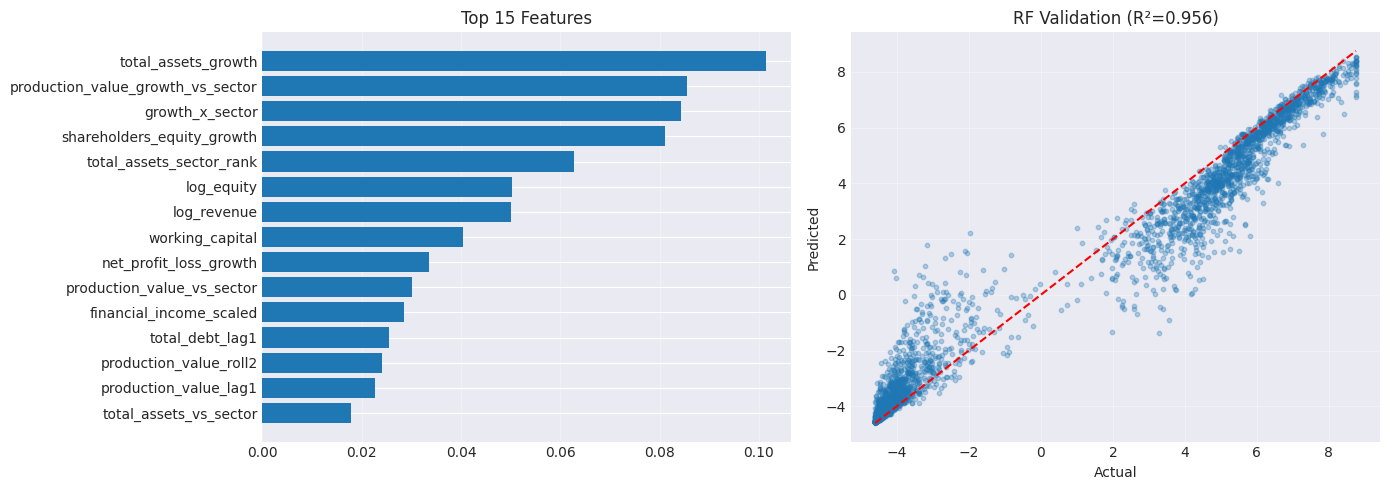


 RANDOMFOREST COMPLETE!


In [ ]:
# ========================================
# CELL 6: RandomForest Baseline - FINAL FIX
# ========================================

import time

print("=" * 80)
print(" RANDOMFOREST BASELINE")
print("=" * 80)

# --------------------------------------------------
# Detect & filter non-numeric features
# --------------------------------------------------
non_numeric_cols = X_train.select_dtypes(exclude="number").columns.tolist()

if non_numeric_cols:
    print(" Non-numeric features detected (excluded for RF):")
    for c in non_numeric_cols:
        sample_vals = X_train[c].dropna().astype(str).unique()[:5]
        print(f" - {c}: sample values {sample_vals}")

numeric_features = X_train.select_dtypes(include="number").columns.tolist()

X_train_rf = X_train[numeric_features]
X_val_rf   = X_val[numeric_features]

print(f"\n✓ Using {len(numeric_features)} numeric features for RandomForest")

# --------------------------------------------------
# Training
# --------------------------------------------------
print("\nTraining RandomForest...")
print("-" * 80)

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

print(f"Training on {len(X_train_rf):,} samples, {X_train_rf.shape[1]} features")

start = time.time()
rf_model.fit(X_train_rf, y_train)
elapsed = time.time() - start

print(f" Trained in {elapsed:.1f} seconds")

# --------------------------------------------------
# Predictions
# --------------------------------------------------
print("\nMaking predictions...")
rf_pred_train = rf_model.predict(X_train_rf)
rf_pred_val   = rf_model.predict(X_val_rf)
print(" Predictions complete")

# --------------------------------------------------
# Evaluation
# --------------------------------------------------
print("\n TRAINING PERFORMANCE:")
print("-" * 80)
rf_train = evaluate_model(
    y_train,
    rf_pred_train,
    y_train_original,
    model_name="RF_train"
)

print(f"Eps-MAPE: {rf_train['Eps_MAPE']:.2f}%")
print(f"R² (log): {rf_train['R2_log']:.4f}")

print("\n VALIDATION PERFORMANCE:")
print("-" * 80)
rf_val = evaluate_model(
    y_val,
    rf_pred_val,
    y_val_original,
    model_name="RF_val"
)

print(f"Eps-MAPE: {rf_val['Eps_MAPE']:.2f}%")
print(f"WAPE:     {rf_val['WAPE']:.2f}%")
print(f"sMAPE:    {rf_val['sMAPE']:.2f}%")
print(f"R² (log): {rf_val['R2_log']:.4f}")
print(f"Dir Acc:  {rf_val['Dir_Acc']:.1f}%")

results.append(rf_val)

# --------------------------------------------------
# Overfitting check
# --------------------------------------------------
gap = rf_val["Eps_MAPE"] - rf_train["Eps_MAPE"]
print(f"\n Overfitting gap: {gap:.2f}%")

if np.isnan(gap):
    print(" Overfitting check skipped (NaN)")
elif gap > 5:
    print(" Possible overfitting (gap > 5%)")
else:
    print(" No significant overfitting")

# --------------------------------------------------
# Feature Importance
# --------------------------------------------------
print("\n TOP 15 FEATURES:")
print("-" * 80)

feat_imp = (
    pd.DataFrame({
        "Feature": numeric_features,
        "Importance": rf_model.feature_importances_
    })
    .sort_values("Importance", ascending=False)
)

print(feat_imp.head(15).to_string(index=False))

# --------------------------------------------------
# Visualization
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Feature importance
top15 = feat_imp.head(15)
axes[0].barh(range(len(top15)), top15["Importance"].values)
axes[0].set_yticks(range(len(top15)))
axes[0].set_yticklabels(top15["Feature"].values)
axes[0].invert_yaxis()
axes[0].set_title("Top 15 Features")
axes[0].grid(axis="x", alpha=0.3)

# Actual vs Predicted
axes[1].scatter(y_val, rf_pred_val, alpha=0.3, s=10)
min_v, max_v = y_val.min(), y_val.max()
axes[1].plot([min_v, max_v], [min_v, max_v], "r--")
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predicted")
axes[1].set_title(f"RF Validation (R²={rf_val['R2_log']:.3f})")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print(" RANDOMFOREST COMPLETE")
print("=" * 80)


Initial XGBoost Model

🚀 XGBOOST BASELINE (Default Parameters)

Selecting numeric features...
--------------------------------------------------------------------------------
⚠️  Excluding 4 non-numeric features:
   - province
   - region
   - legal_form
   - financial_health_class

✅ Using 56 numeric features for XGBoost

Initializing XGBoost...
--------------------------------------------------------------------------------
Parameters (default/conservative):
  - n_estimators: 100
  - max_depth: 6
  - learning_rate: 0.1
  - subsample: 0.8
  - colsample_bytree: 0.8

Training on 5,897 samples, 56 features...
✅ Trained in 0.9 seconds

Making predictions...
✅ Predictions complete

📊 TRAINING PERFORMANCE:
--------------------------------------------------------------------------------
Eps-MAPE: 45.14%
R² (log): 0.8269

📊 VALIDATION PERFORMANCE:
--------------------------------------------------------------------------------
Eps-MAPE: 29.85%
WAPE:     54.41%
sMAPE:    42.71%
R² (log): 0.9815
Dir Acc:  99.3%

🔍 Ov

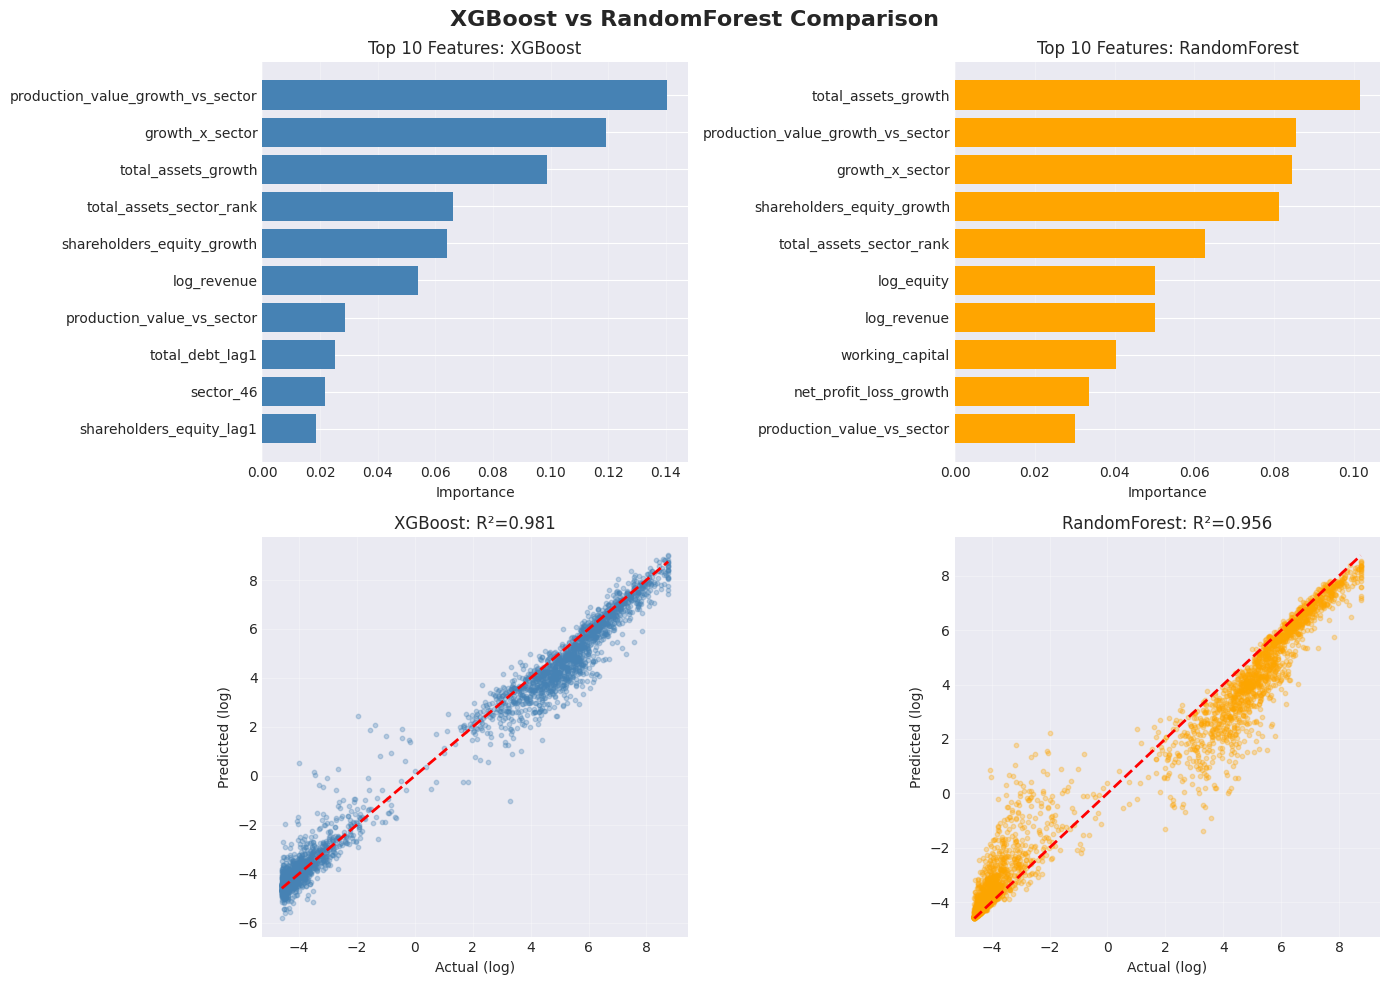


✅ XGBOOST BASELINE COMPLETE!


In [ ]:
# ========================================
# CELL 7: Initial XGBoost Model - FIXED
# ========================================

print("="*80)
print(" XGBOOST BASELINE (Default Parameters)")
print("="*80)

import time

# Select ONLY NUMERIC features (same as RandomForest)
print("\nSelecting numeric features...")
print("-"*80)

# Get numeric columns
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Check for any non-numeric
non_numeric = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

if non_numeric:
    print(f"  Excluding {len(non_numeric)} non-numeric features:")
    for col in non_numeric:
        print(f"   - {col}")

print(f"\n Using {len(numeric_features)} numeric features for XGBoost")

# Create numeric-only datasets
X_train_numeric = X_train[numeric_features]
X_val_numeric = X_val[numeric_features]

# Verify no missing values
train_missing = X_train_numeric.isnull().sum().sum()
val_missing = X_val_numeric.isnull().sum().sum()

if train_missing > 0 or val_missing > 0:
    print(f"\n  Found missing values: train={train_missing}, val={val_missing}")
    print("Filling with 0...")
    X_train_numeric = X_train_numeric.fillna(0)
    X_val_numeric = X_val_numeric.fillna(0)
    print(" Missing values filled")

# Initialize XGBoost
print("\n" + "="*80)
print("Initializing XGBoost...")
print("-"*80)

xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method='hist'
)

print("Parameters (default/conservative):")
print(f"  - n_estimators: 100")
print(f"  - max_depth: 6")
print(f"  - learning_rate: 0.1")
print(f"  - subsample: 0.8")
print(f"  - colsample_bytree: 0.8")

# Train
print(f"\nTraining on {len(X_train_numeric):,} samples, {X_train_numeric.shape[1]} features...")

start = time.time()
xgb_model.fit(X_train_numeric, y_train, verbose=False)
elapsed = time.time() - start

print(f" Trained in {elapsed:.1f} seconds")

# Predictions
print("\nMaking predictions...")
xgb_pred_train = xgb_model.predict(X_train_numeric)
xgb_pred_val = xgb_model.predict(X_val_numeric)
print(" Predictions complete")

# Evaluate on train
print("\n TRAINING PERFORMANCE:")
print("-"*80)
xgb_train = evaluate_model(y_train, xgb_pred_train, y_train_original, "XGB_train")
print(f"Eps-MAPE: {xgb_train['Eps_MAPE']:.2f}%")
print(f"R² (log): {xgb_train['R2_log']:.4f}")

# Evaluate on validation
print("\n VALIDATION PERFORMANCE:")
print("-"*80)
xgb_val = evaluate_model(y_val, xgb_pred_val, y_val_original, "XGB_val")
print(f"Eps-MAPE: {xgb_val['Eps_MAPE']:.2f}%")
print(f"WAPE:     {xgb_val['WAPE']:.2f}%")
print(f"sMAPE:    {xgb_val['sMAPE']:.2f}%")
print(f"R² (log): {xgb_val['R2_log']:.4f}")
print(f"Dir Acc:  {xgb_val['Dir_Acc']:.1f}%")

results.append(xgb_val)

# Overfitting check
gap = xgb_val['Eps_MAPE'] - xgb_train['Eps_MAPE']
print(f"\n Overfitting gap: {gap:.2f}%")
if gap > 5:
    print("  Possible overfitting (gap > 5%)")
else:
    print(" No significant overfitting")

# Feature importance
print("\n TOP 15 FEATURES (XGBoost):")
print("-"*80)

xgb_feat_imp = pd.DataFrame({
    'Feature': numeric_features,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(xgb_feat_imp.head(15).to_string(index=False))

# Comparison with all models
print("\n" + "="*80)
print(" ALL MODELS COMPARISON:")
print("="*80)

all_models = pd.DataFrame(results).sort_values('Eps_MAPE')
print("\n" + all_models[['Model', 'Eps_MAPE', 'WAPE', 'sMAPE', 'R2_log', 'Dir_Acc']].to_string(index=False))

# Best model
best_model = all_models.iloc[0]
print(f"\n BEST MODEL: {best_model['Model']}")
print(f"   Eps-MAPE: {best_model['Eps_MAPE']:.2f}%")
print(f"   R² (log): {best_model['R2_log']:.4f}")
print(f"   Dir Acc:  {best_model['Dir_Acc']:.1f}%")

# XGBoost vs RF
rf_mape = all_models[all_models['Model'] == 'RF_val']['Eps_MAPE'].values[0]
xgb_mape = xgb_val['Eps_MAPE']

print(f"\n XGBoost vs RandomForest:")
print(f"   RandomForest: {rf_mape:.2f}%")
print(f"   XGBoost:      {xgb_mape:.2f}%")

if xgb_mape < rf_mape:
    improvement = ((rf_mape - xgb_mape) / rf_mape) * 100
    print(f"   XGBoost wins by {improvement:.1f}%! ✅")
elif xgb_mape > rf_mape:
    diff = ((xgb_mape - rf_mape) / rf_mape) * 100
    print(f"   RandomForest is better by {diff:.1f}%")
else:
    print("   Tied!")

# Improvement over baselines
best_baseline = all_models[all_models['Model'].isin(['Zero', 'Mean', 'Median'])]['Eps_MAPE'].min()
best_ml = min(rf_mape, xgb_mape)
total_improvement = ((best_baseline - best_ml) / best_baseline) * 100

print(f"\n OVERALL PROGRESS:")
print(f"   Best Baseline:  {best_baseline:.2f}%")
print(f"   Best ML Model:  {best_ml:.2f}%")
print(f"   Improvement:    {total_improvement:.1f}%")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('XGBoost vs RandomForest Comparison', fontsize=16, fontweight='bold')

# 1. Feature importance: XGBoost
top10_xgb = xgb_feat_imp.head(10)
axes[0, 0].barh(range(10), top10_xgb['Importance'].values, color='steelblue')
axes[0, 0].set_yticks(range(10))
axes[0, 0].set_yticklabels(top10_xgb['Feature'].values)
axes[0, 0].invert_yaxis()
axes[0, 0].set_xlabel('Importance')
axes[0, 0].set_title('Top 10 Features: XGBoost')
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Feature importance: RandomForest
top10_rf = feat_imp.head(10)
axes[0, 1].barh(range(10), top10_rf['Importance'].values, color='orange')
axes[0, 1].set_yticks(range(10))
axes[0, 1].set_yticklabels(top10_rf['Feature'].values)
axes[0, 1].invert_yaxis()
axes[0, 1].set_xlabel('Importance')
axes[0, 1].set_title('Top 10 Features: RandomForest')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Actual vs Predicted: XGBoost
axes[1, 0].scatter(y_val, xgb_pred_val, alpha=0.3, s=10, color='steelblue')
axes[1, 0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual (log)')
axes[1, 0].set_ylabel('Predicted (log)')
axes[1, 0].set_title(f'XGBoost: R²={xgb_val["R2_log"]:.3f}')
axes[1, 0].grid(True, alpha=0.3)

# 4. Actual vs Predicted: RandomForest
axes[1, 1].scatter(y_val, rf_pred_val, alpha=0.3, s=10, color='orange')
axes[1, 1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual (log)')
axes[1, 1].set_ylabel('Predicted (log)')
axes[1, 1].set_title(f'RandomForest: R²={rf_val["R2_log"]:.3f}')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print(" XGBOOST BASELINE COMPLETE!")
print("="*80)